In [1]:
import sys
sys.executable

'd:\\Documents\\AutoScaling Analysis\\Autoscaling-Analysis\\venv\\Scripts\\python.exe'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime

LOG_PATTERN = re.compile(r'(?P<host>\S+) - - \[(?P<timestamp>.*?)\] "(?P<request>.*?)" (?P<status>\d{3}) (?P<bytes>\S+)')

In [3]:
# Parse một dòng log raw thành dictionary
def parse_log_line(line):
    match = LOG_PATTERN.match(line)
    if match:
        data = match.groupdict()
        data['bytes'] = 0 if data['bytes'] == '-' else int(data['bytes'])
        data['status'] = int(data['status'])
        return data
    return None

# Đọc file txt và trả về DataFrame
def load_and_process_logs(file_paths):
    parsed_data = []
    
    for file_path in file_paths:
        if not os.path.exists(file_path):
            print(f"Warning: File {file_path} not found. Skipping.")
            continue
            
        print(f"Reading file: {file_path}...")
        with open(file_path, 'r', encoding='latin-1') as f:
            for line in f:
                parsed = parse_log_line(line)
                if parsed:
                    parsed_data.append(parsed)
    
    if not parsed_data:
        return pd.DataFrame()

    df = pd.DataFrame(parsed_data)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
    
    df = df.sort_values('timestamp')
    
    return df

In [4]:
os.getcwd()

'd:\\Documents\\AutoScaling Analysis\\Autoscaling-Analysis\\notebooks\\final'

In [5]:
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent.parent
DATA_RAW_DIR =  PROJECT_ROOT / "data" / "raw"
DATA_CLEANED_DIR = PROJECT_ROOT / "data" / "cleaned"

In [6]:
train_log_path = DATA_RAW_DIR / "train.txt"
test_log_path  = DATA_RAW_DIR / "test.txt"

log_files = [train_log_path, test_log_path]
raw_df = load_and_process_logs(log_files)

print(f"Shape of Data: {raw_df.shape}")

Reading file: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\data\raw\train.txt...
Reading file: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\data\raw\test.txt...
Shape of Data: (3461612, 5)


In [7]:
raw_df.head(5)

,host,timestamp,request,status,bytes
0,199.72.81.55,1995-07-01 00:00:01-04:00,GET /history/apollo/ HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06-04:00,GET /shuttle/countdown/ HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09-04:00,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085
3,burger.letters.com,1995-07-01 00:00:11-04:00,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11-04:00,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179


In [8]:
raw_df.tail(5)

,host,timestamp,request,status,bytes
3461606,gatekeeper.uccu.com,1995-08-31 23:59:49-04:00,GET /images/kscmap-tiny.gif HTTP/1.0,304,0
3461608,gatekeeper.uccu.com,1995-08-31 23:59:49-04:00,GET /images/lc39a-logo.gif HTTP/1.0,304,0
3461610,www-c8.proxy.aol.com,1995-08-31 23:59:52-04:00,GET /icons/unknown.xbm HTTP/1.0,200,515
3461609,cys-cap-9.wyoming.com,1995-08-31 23:59:52-04:00,GET /shuttle/missions/sts-71/movies/sts-71-lau...,200,57344
3461611,cindy.yamato.ibm.co.jp,1995-08-31 23:59:53-04:00,GET /images/kscmap-small.gif HTTP/1.0,200,39017


In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3461612 entries, 0 to 3461611
Data columns (total 5 columns):
 #   Column     Dtype                    
---  ------     -----                    
 0   host       object                   
 1   timestamp  datetime64[ns, UTC-04:00]
 2   request    object                   
 3   status     int64                    
 4   bytes      int64                    
dtypes: datetime64[ns, UTC-04:00](1), int64(2), object(2)
memory usage: 158.5+ MB


In [10]:
def resample_traffic(df, window='5min'):
    df_idx = df.set_index('timestamp')
    
    resampled = df_idx.resample(window).agg({
        'request': 'count',
        'bytes': 'sum',
        'host': 'nunique',
        'status': lambda x: (x >= 400).sum()
    })
    
    resampled.columns = ['requests', 'bytes', 'hosts', 'errors']
    
    # Fill 0 cho những khoảng trống 
    resampled = resampled.fillna(0)
    
    return resampled

df_5m = resample_traffic(raw_df, window='5min')
print("Resampled to 5-minute intervals:")
df_5m.head()

Resampled to 5-minute intervals:


,requests,bytes,hosts,errors
timestamp,,,,
1995-07-01 00:00:00-04:00,301,5277675,60,1
1995-07-01 00:05:00-04:00,267,5041043,53,0
1995-07-01 00:10:00-04:00,242,6111846,55,4
1995-07-01 00:15:00-04:00,282,4559748,55,4
1995-07-01 00:20:00-04:00,319,7262385,66,0


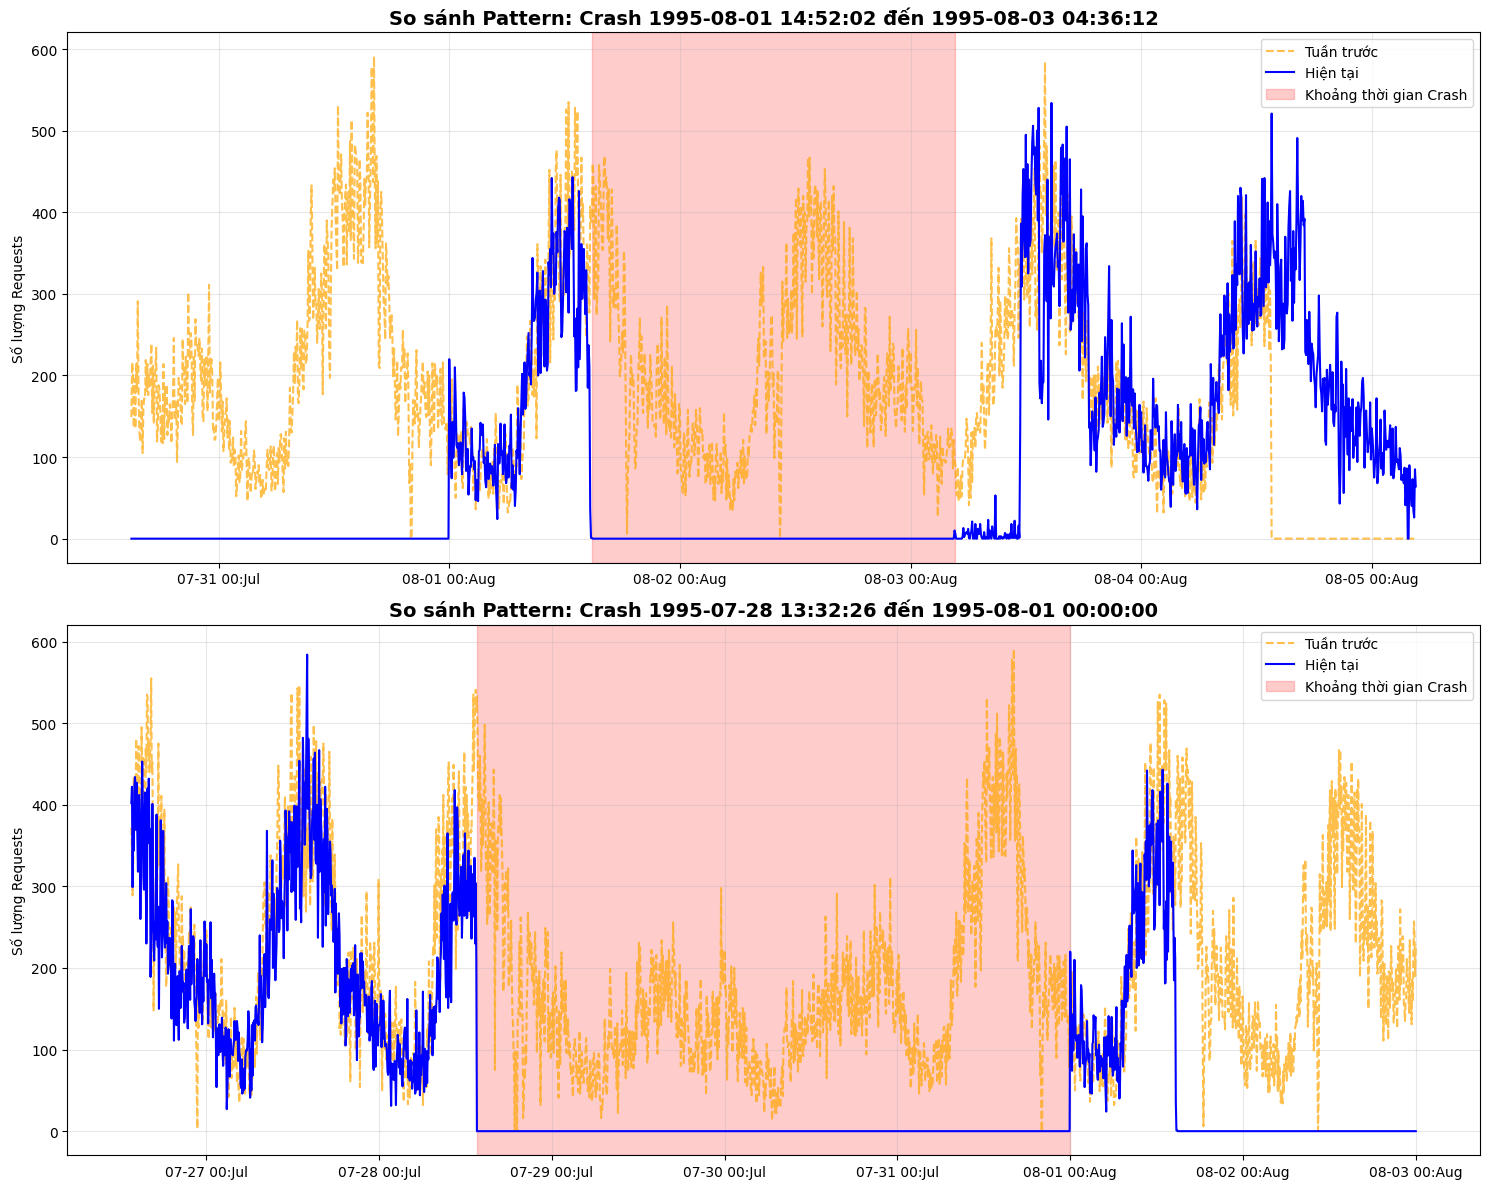

In [11]:
import matplotlib.dates as mdates

def plot_imputation_check(df_input, outages):
    """
    Vẽ biểu đồ so sánh dữ liệu tuần bị crash và tuần trước đó.
    
    Args:
        df: Dữ liệu gốc
        outages: List các tuple (start_time, end_time) hệ thống bị down
    """
    df = df_input.copy()
    df.index = df.index.tz_localize(None)
    # Cấu hình plot
    fig, axes = plt.subplots(nrows=len(outages),ncols= 1, figsize=(15, 6 * len(outages)))
    if len(outages) == 1: axes = [axes] 
    
    # Khoảng offset 7 ngày 
    offset_7d = pd.Timedelta(days=7)

    for i, (start, end) in enumerate(outages):
        ax = axes[i]
        
        # 1. Xác định khung nhìn 
        # Lấy rộng ra mỗi bên 2 ngày để thấy context trước và sau khi sập
        start_dt = pd.to_datetime(start)
        end_dt = pd.to_datetime(end)
        
        view_start = start_dt - pd.Timedelta(days=2)
        view_end = end_dt + pd.Timedelta(days=2)
        
        # 2. Lấy dữ liệu
        # Data tuần bị crash (Current)
        mask_current = (df.index >= view_start) & (df.index <= view_end)
        df_current = df.loc[mask_current]
        
        # Data tuần trước đó dùng để Impute
        # Lấy lùi về 7 ngày
        mask_past = (df.index >= (view_start - offset_7d)) & (df.index <= (view_end - offset_7d))
        df_past = df.loc[mask_past].copy()
        
        df_past.index = df_past.index + offset_7d

        ax.plot(df_past.index, df_past['requests'], 
                color='orange', linestyle='--', alpha=0.7, label='Tuần trước')
        
        ax.plot(df_current.index, df_current['requests'], 
                color='blue', linewidth=1.5, label='Hiện tại')
        
        ax.axvspan(start_dt, end_dt, color='red', alpha=0.2, label='Khoảng thời gian Crash')
        
        ax.set_title(f'So sánh Pattern: Crash {start} đến {end}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Số lượng Requests')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%h'))

    plt.tight_layout()
    plt.show()


outages = [
    ('1995-08-01 14:52:02', '1995-08-03 04:36:12'),
    ('1995-07-28 13:32:26', '1995-08-01 00:00:00')
]

plot_imputation_check(df_5m, outages)

In [12]:
def add_features(df_input, frequency='5m'):
    df = df_input.copy()
    
    # Xác định các tham số dựa vào tần suất
    if frequency == '1m':
        lag_1_steps = 1        # 1 phút
        lag_1h_steps = 60      # 1 giờ
        lag_24h_steps = 1440   # 24 giờ
        lag_7d_steps = 10080   # 7 ngày
        window_1h = 60         # 1 giờ
        window_24h = 1440      # 24 giờ
    elif frequency == '5m':
        lag_1_steps = 1        # 5 phút
        lag_1h_steps = 12      # 1 giờ (60/5)
        lag_24h_steps = 288    # 24 giờ (1440/5)
        lag_7d_steps = 2016    # 7 ngày (10080/5)
        window_1h = 12
        window_24h = 288
    elif frequency == '15m':
        lag_1_steps = 1        # 15 phút
        lag_1h_steps = 4       # 1 giờ (60/15)
        lag_24h_steps = 96     # 24 giờ (1440/15)
        lag_7d_steps = 672     # 7 ngày (10080/15)
        window_1h = 4
        window_24h = 96
    else:
        raise ValueError(f"Frequency '{frequency}' không được hỗ trợ. Hãy chọn: '1m', '5m', hoặc '15m'")

    outages = [
        ('1995-08-01 14:52:02', '1995-08-03 04:36:12'),
        ('1995-07-28 13:32:26', '1995-08-01 00:00:00')
    ]

    df['error_rate'] = df['errors'] / (df['requests'] + 1e-9)
    df['error_rate'] = df['error_rate'].fillna(0.0)

    df['requests_target'] = df['requests']

    for start, end in outages:
        mask = (df.index >= start) & (df.index <= end)
        df.loc[mask, 'requests_target'] = df['requests'].shift(lag_7d_steps).loc[mask]
        df.loc[mask, 'error_rate'] = df['error_rate'].shift(lag_7d_steps).loc[mask]

    df['requests_target'] = df['requests_target'].fillna(method='ffill').fillna(0)
    df['error_rate']      = df['error_rate'].fillna(method='ffill').fillna(0)

    target_for_lag = 'requests_target'

    df['req_lag_1']   = df[target_for_lag].shift(lag_1_steps)
    df['req_lag_12']  = df[target_for_lag].shift(lag_1h_steps) 
    df['req_lag_288'] = df[target_for_lag].shift(lag_24h_steps)

    df['rolling_mean_1h'] = df[target_for_lag].rolling(window=window_1h).mean()
    df['rolling_std_1h']  = df[target_for_lag].rolling(window=window_1h).std()

    df['rolling_mean_24h'] = df[target_for_lag].rolling(window=window_24h).mean()
    
    df['err_lag_1'] = df['error_rate'].shift(lag_1_steps)
    df['err_rolling_mean_1h'] = df['error_rate'].rolling(window=window_1h).mean()
 
    # Extract Time Features (Cyclic)
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'] >= 5

    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    df = df.dropna()
    
    # Type Casting 
    df['requests'] = df['requests'].astype(int)
    df['bytes'] = df['bytes'].astype(int)
    df['hosts'] = df['hosts'].astype(int)
    df['hour_of_day'] = df['hour_of_day'].astype(int)
    df['day_of_week'] = df['day_of_week'].astype(int)
    df['is_weekend'] = df['is_weekend'].astype(int)
    df['error_rate'] = df['error_rate'].astype(float)
    df['requests_target'] = df['requests_target'].astype(int)
    
    return df


In [13]:
df_5m_final = add_features(df_5m, frequency='5m')
df_5m_final.tail()

C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['requests_target'] = df['requests_target'].fillna(method='ffill').fillna(0)
C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['error_rate']      = df['error_rate'].fillna(method='ffill').fillna(0)


,requests,bytes,hosts,errors,error_rate,requests_target,req_lag_1,req_lag_12,req_lag_288,rolling_mean_1h,rolling_std_1h,rolling_mean_24h,err_lag_1,err_rolling_mean_1h,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
timestamp,,,,,,,,,,,,,,,,,,,
1995-08-31 23:35:00-04:00,277,4183450,43,0,0.000000,277,219.0,299.0,221.0,235.666667,32.761766,315.135417,0.009132,0.009279,23,3,0,-0.258819,0.965926
1995-08-31 23:40:00-04:00,170,4511364,41,4,0.023529,170,277.0,239.0,291.0,229.916667,37.792395,314.715278,0.000000,0.011239,23,3,0,-0.258819,0.965926
1995-08-31 23:45:00-04:00,145,2805157,36,1,0.006897,145,170.0,220.0,359.0,223.666667,45.080400,313.972222,0.023529,0.011814,23,3,0,-0.258819,0.965926
1995-08-31 23:50:00-04:00,174,1883814,36,0,0.000000,174,145.0,232.0,293.0,218.833333,47.166693,313.559028,0.006897,0.011814,23,3,0,-0.258819,0.965926
1995-08-31 23:55:00-04:00,123,2315469,32,0,0.000000,123,174.0,292.0,303.0,204.750000,48.544497,312.934028,0.000000,0.010958,23,3,0,-0.258819,0.965926


In [14]:
df_5m_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:55:00-04:00
Freq: 5min
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             17568 non-null  int64  
 1   bytes                17568 non-null  int64  
 2   hosts                17568 non-null  int64  
 3   errors               17568 non-null  int64  
 4   error_rate           17568 non-null  float64
 5   requests_target      17568 non-null  int64  
 6   req_lag_1            17568 non-null  float64
 7   req_lag_12           17568 non-null  float64
 8   req_lag_288          17568 non-null  float64
 9   rolling_mean_1h      17568 non-null  float64
 10  rolling_std_1h       17568 non-null  float64
 11  rolling_mean_24h     17568 non-null  float64
 12  err_lag_1            17568 non-null  float64
 13  err_rolling_mean_1h  17568 non-null  float64
 14  hour_of_day          17568 n

In [15]:
df_1m = resample_traffic(raw_df, window='1min')
df_1m_final = add_features(df_1m, frequency='1m')
df_1m_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87840 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:59:00-04:00
Freq: min
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             87840 non-null  int64  
 1   bytes                87840 non-null  int64  
 2   hosts                87840 non-null  int64  
 3   errors               87840 non-null  int64  
 4   error_rate           87840 non-null  float64
 5   requests_target      87840 non-null  int64  
 6   req_lag_1            87840 non-null  float64
 7   req_lag_12           87840 non-null  float64
 8   req_lag_288          87840 non-null  float64
 9   rolling_mean_1h      87840 non-null  float64
 10  rolling_std_1h       87840 non-null  float64
 11  rolling_mean_24h     87840 non-null  float64
 12  err_lag_1            87840 non-null  float64
 13  err_rolling_mean_1h  87840 non-null  float64
 14  hour_of_day          87840 no

C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['requests_target'] = df['requests_target'].fillna(method='ffill').fillna(0)
C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['error_rate']      = df['error_rate'].fillna(method='ffill').fillna(0)


In [16]:
df_1m_final['1995-07-28 13:32:25':'1995-08-01 00:00:01']

,requests,bytes,hosts,errors,error_rate,requests_target,req_lag_1,req_lag_12,req_lag_288,rolling_mean_1h,rolling_std_1h,rolling_mean_24h,err_lag_1,err_rolling_mean_1h,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
timestamp,,,,,,,,,,,,,,,,,,,
1995-07-28 13:33:00-04:00,0,0,0,0,0.000000,77,42.0,41.0,86.0,58.216667,14.353989,40.099306,0.023810,0.001344,13,4,0,-0.258819,-0.965926
1995-07-28 13:34:00-04:00,0,0,0,0,0.000000,100,77.0,62.0,72.0,58.850000,15.328963,40.118750,0.000000,0.000806,13,4,0,-0.258819,-0.965926
1995-07-28 13:35:00-04:00,0,0,0,0,0.011628,86,100.0,77.0,96.0,59.000000,15.551990,40.111806,0.000000,0.001000,13,4,0,-0.258819,-0.965926
1995-07-28 13:36:00-04:00,0,0,0,0,0.000000,106,86.0,42.0,55.0,60.066667,16.530267,40.147222,0.011628,0.001000,13,4,0,-0.258819,-0.965926
1995-07-28 13:37:00-04:00,0,0,0,0,0.000000,102,106.0,60.0,61.0,60.766667,17.394103,40.175694,0.000000,0.001000,13,4,0,-0.258819,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-07-31 23:56:00-04:00,0,0,0,0,0.048780,41,22.0,23.0,31.0,30.333333,14.217042,44.675694,0.045455,0.013625,23,0,0,-0.258819,0.965926
1995-07-31 23:57:00-04:00,0,0,0,0,0.000000,28,41.0,54.0,54.0,29.900000,13.875597,44.657639,0.048780,0.013625,23,0,0,-0.258819,0.965926
1995-07-31 23:58:00-04:00,0,0,0,0,0.000000,27,28.0,27.0,47.0,29.900000,13.875597,44.643750,0.000000,0.013625,23,0,0,-0.258819,0.965926


In [17]:
df_15m = resample_traffic(raw_df, window='15min')
df_15m_final = add_features(df_15m, frequency='15m')
df_15m_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:45:00-04:00
Freq: 15min
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             5856 non-null   int64  
 1   bytes                5856 non-null   int64  
 2   hosts                5856 non-null   int64  
 3   errors               5856 non-null   int64  
 4   error_rate           5856 non-null   float64
 5   requests_target      5856 non-null   int64  
 6   req_lag_1            5856 non-null   float64
 7   req_lag_12           5856 non-null   float64
 8   req_lag_288          5856 non-null   float64
 9   rolling_mean_1h      5856 non-null   float64
 10  rolling_std_1h       5856 non-null   float64
 11  rolling_mean_24h     5856 non-null   float64
 12  err_lag_1            5856 non-null   float64
 13  err_rolling_mean_1h  5856 non-null   float64
 14  hour_of_day          5856 no

C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['requests_target'] = df['requests_target'].fillna(method='ffill').fillna(0)
C:\Users\admin\AppData\Local\Temp\ipykernel_12876\3210510215.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['error_rate']      = df['error_rate'].fillna(method='ffill').fillna(0)


In [ ]:
data_1m_path = DATA_CLEANED_DIR / 'data_1m.csv'
data_5m_path = DATA_CLEANED_DIR / 'data_5m.csv'
data_15m_path = DATA_CLEANED_DIR / 'data_15m.csv'

df_1m_final.to_csv(data_1m_path, index=True)
df_5m_final.to_csv(data_5m_path, index=True)
df_15m_final.to_csv(data_15m_path, index=True)